Written by Jorge: 20240426

Copied from 1e_EEGNET..

On this notebook I will try to train different models and save them to retrieve later. The idea is to check wich ones have the best performance.
Also, I would like to implement the feature to save the predictions and the labels, so I can build a ROC curve later.



# **1. Instancies and libraries**

## 1.1 Install MNE to visualize and, potentially, process EEG data

In [80]:
pip install mne

## 1.2 Add EEGNet library to the environmental variable

In [81]:
import sys
path = "/content/EEGNet"
sys.path.append(path)

## 1.3 **Import** the main libraries. This ones will be used across all the program

In [83]:
# Filesystem
import os
import zipfile

# data processing
import numpy as np
import pandas as pd

# AI-related
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
import itertools

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# MNE
import mne
from mne import io

#EEGNET
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K


# **2. Functions**

## 2.1 Function to visualize the performance of the model

In [84]:
def visualize_results (model, n_epochs):
  epochs = [i for i in range (n_epochs)]
  fig, ax = plt.subplots(1,2)
  train_acc = model.history["accuracy"]
  train_loss = model.history["loss"]
  val_acc = model.history["val_accuracy"]
  val_loss = model.history["val_loss"]
  fig.set_size_inches(16,9)

  ax[0].plot(epochs, train_acc, "go-", label = "Training Accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label = "Validation Accuracy")
  ax[0].set_title("Training and Validation Accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label = "Training Loss")
  ax[1].plot(epochs, val_loss, "ro-", label = "Validation Loss")
  ax[1].set_title("Training and Validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

## 2.2 **Function** to plot Confusion Matrix

In [85]:
def plot_confusion_matrix (cm,
                           classes,
                           normalize = False,
                           title = 'Confusion Matrix',
                           cmap=plt.cm.Blues
                          ):
  plt.imshow (cm, interpolation='nearest', cmap=cmap)
  plt.title (title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product (range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, round(cm[i,j],2),
              horizontalalignment="center",
              color="gainsboro" if cm [i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')

## 2.3 Function to normalize EEG data (run inside the loop to assemble the tensor)

In [86]:
def normalize_channels (data, n_channels):
  data_norm = np.zeros_like(data, dtype='float32')
  for ch in range (n_channels):
      min_val = (np.min(data[ch]))
      max_val = (np.max(data[ch]))
      data_norm [ch] = (data[ch] - min_val) / (max_val - min_val)

  return data_norm

# **3. Data Load**

## 3.1 Unzip dataset

In [87]:
local_zip = "/content/ERP_Pretest_Data_128Hz.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/ERP_Pretest_Data_128_Hz")
zip_ref.close()

## 3.2 Define file paths

In [88]:
train_data_path = "/content/ERP_Pretest_Data_128_Hz/Train/"
test_data_path = "/content/ERP_Pretest_Data_128_Hz/Test/"

## 3.3 Load file lists

In [89]:
trainlist = open  ("/content/ERP_Pretest_Data_128_Hz/TrainFileList.txt", "r")
data = trainlist.read()
train_data_all_files = data.split("\n")

testlist = open  ("/content/ERP_Pretest_Data_128_Hz/TestFileList.txt", "r")
data_ = testlist.read()
test_data_all_files = data_.split("\n")

## 3.4 Determine the number of trials available based on the number of files

In [90]:
n_trials_train = len(train_data_all_files)
n_trials_test = len(test_data_all_files)

## 3.5 Define the parameters for EEG data

In [91]:
n_channels = 20
n_samples = 128
n_kernels = 1

ch_names = ['Fz', 'F7', 'F3', 'F4', 'F8',
            'T7', 'C3', 'CZ', 'C4', 'T8',
            'P7', 'P3', 'Pz', 'P4', 'P8',
            'O1', 'Oz', 'O2', 'LM', 'RM']

sfreq = 128
info = mne.create_info(ch_names = ch_names, sfreq = sfreq)

## 3.6 Load training data

This data will be loaded as 2D array for augmentation and balancing

In [92]:
train_set_2D = np.zeros ((n_trials_train,n_channels*n_samples), dtype='float32')

In [93]:
trial = 0
for filename in train_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  train_set_2D[trial:] = trl
  trial=trial+1

Load labels for training data

In [94]:
train_labels_path = '/content/ERP_Pretest_Data_128_Hz/TrainLabels.csv'
train_labels = np.array(pd.read_csv(train_labels_path, header=None, dtype='uint8'))
train_labels = np.squeeze(train_labels.T)

Balance the training set using the Random Oversampler

In [95]:
oversampler_train = RandomOverSampler(sampling_strategy='minority')
traindata_over, trainlabels_over = oversampler_train.fit_resample(train_set_2D, train_labels)
(overTrials_tr, overSamples_tr) = traindata_over.shape

Allocate data in tensor

In [96]:
X_train = np.zeros((overTrials_tr,n_channels,n_samples), dtype=np.float32)

In [97]:
for i in range(overTrials_tr):
  trl_rs = np.reshape (traindata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  # trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_train[i] = trl_rs

# reasign the training labels
y_train = trainlabels_over
print(y_train.shape)

(1342,)


Visualize the first trial in the set

Creating RawArray with float64 data, n_channels=20, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


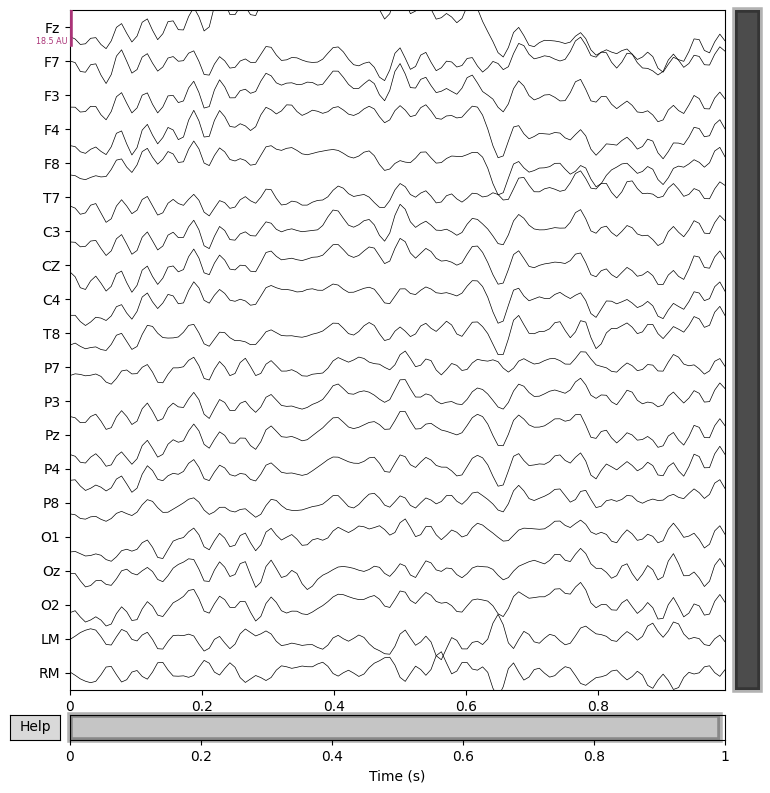

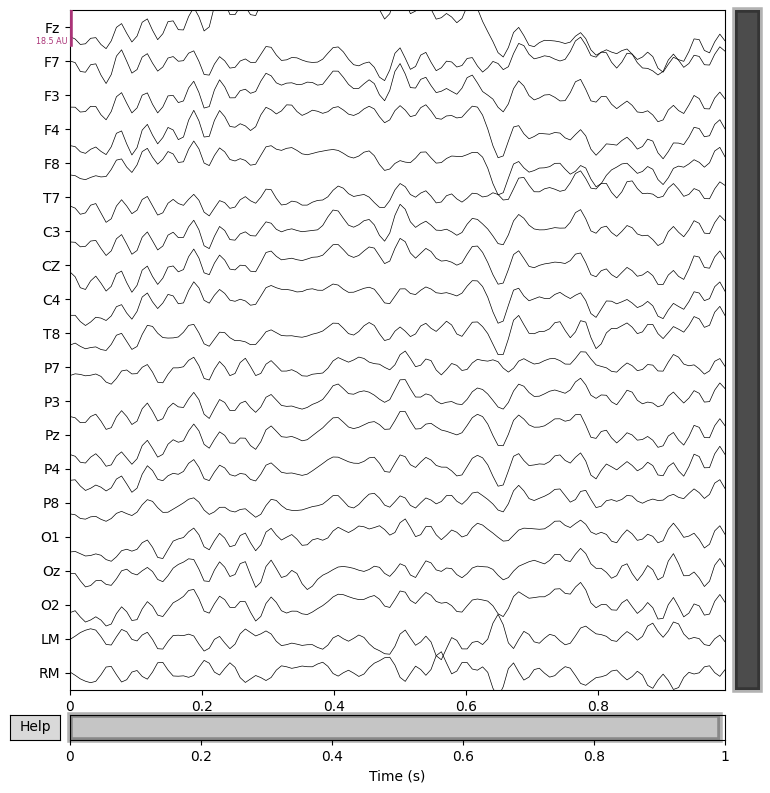

In [98]:
example = mne.io.RawArray(X_train[0], info)
example.plot(block=True)

## 3.7 Load test data

This is a similar process to loading the training data, we perform oversampling here too

In [99]:
test_set_2D = np.zeros ((n_trials_test,n_channels*n_samples), dtype='float32')

In [100]:
trial = 0
for filename in test_data_all_files:
  data = pd.read_csv(filename, header=None, dtype=np.float32)
  trl = np.reshape (np.array(data), (n_channels*n_samples))
  test_set_2D[trial:] = trl
  trial=trial+1

Load test data labels

In [101]:
test_labels_path = '/content/ERP_Pretest_Data_128_Hz/TestLabels.csv'
test_labels = np.array(pd.read_csv(test_labels_path, header=None, dtype='uint8'))
test_labels = np.squeeze(test_labels.T)

Balance with Random Oversampler

In [102]:
oversampler_test = RandomOverSampler(sampling_strategy='minority')
testdata_over, testlabel_over = oversampler_test.fit_resample(test_set_2D, test_labels)
(overTrials_ts,overSamples_ts) = testdata_over.shape

Allocate in tensor

In [103]:
X_test = np.zeros((overTrials_ts,n_channels,n_samples), dtype=np.float32)

In [104]:
for i in range(overTrials_ts):
  trl_rs = np.reshape (testdata_over[i],(n_channels,n_samples))
  # Optional operation to check if this improves the model performance
  # trl_rs = normalize_channels(np.array(trl_rs, dtype='float32'), n_channels)
  X_test[i] = trl_rs

# reasign the training labels
y_test = testlabel_over
print(y_test.shape)

(350,)


Visualize example

Creating RawArray with float64 data, n_channels=20, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.992 secs
Ready.


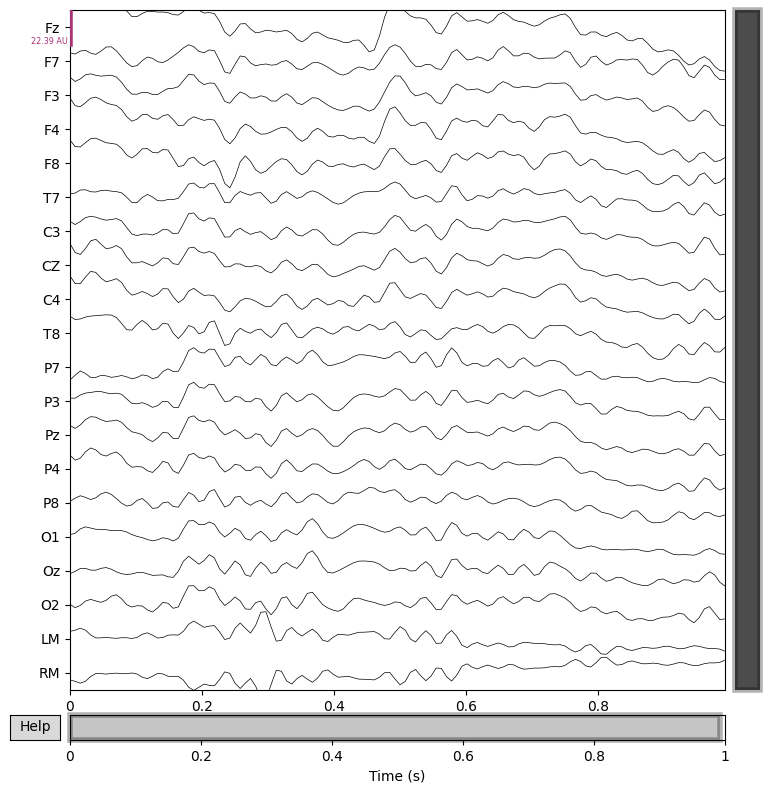

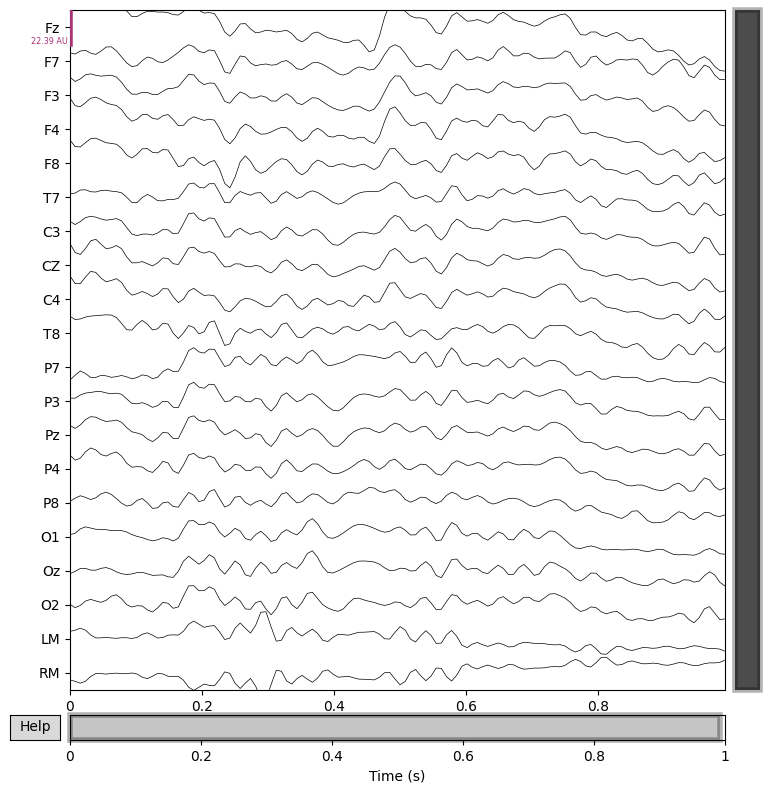

In [105]:
test_example = mne.io.RawArray(X_test[0], info)
test_example.plot(block=True)

In [106]:
print(X_train.shape)
print(X_test.shape)

(1342, 20, 128)
(350, 20, 128)


# **4. EEGNet Portion**

## 4.1 Define model architecture

Parameters for model training, let's start with the defaults

In [107]:
# Model Build
classes = 2
dropout_rate = 0.2                  # hp.Float  ('dropoutRate',  min_value=0.2, max_value=0.5, sampling="log")
kernel_length = 64                  # hp.Choice ('kernLength', values = [16, 32, 64])
f1 = 8                              # hp.Choice ('F1', values = [4, 8])
d = 2                               # hp.Choice ('D', values = [1, 2])
f2 = f1*d
dropout_type = 'SpatialDropout2D'   # hp.Choice ('dropoutType', values = ['Dropout', 'SpatialDropout'])

# Compile
lr = 1e-4                           # hp.Float  ('learning_rate',  min_value=1e-6, max_value=1e-2, sampling="log")

batch = 32
epoch = 300

Callback Block

In [108]:
#Checkpointer
checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint1.h5',
                                   frequency = "epoch",
                                   save_weights_only = False,
                                   monitor = "val_accuracy",
                                   save_best_only=True,
                                   verbose = 1)

Create the EEGNet model with the parameters above

In [109]:
EEGNET_Model0 = EEGNet(nb_classes = classes,
                       Chans = n_channels,
                       Samples = n_samples,
                       dropoutRate = dropout_rate,
                       kernLength = kernel_length,
                       F1 = f1,
                       D = d,
                       F2 = f2,
                       dropoutType = dropout_type)

EEGNET_Model0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 128, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 128, 8)        512       
                                                                 
 batch_normalization_6 (Bat  (None, 20, 128, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_2 (Depthw  (None, 1, 128, 16)        320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 1, 128, 16)        64        
 chNormalization)                                                
                                                           

Let's save the architecture to use it in other models

In [110]:
EEGNET_Template = EEGNET_Model0.get_config ()


 ****

****UP TO THIS POINT EVERYTHING IS FIXED, FROM HERE ON WE START TO ITERATE****

***


## 4.2 Generate validation data

First we generate an array containing all the possible indeces in the training set. From this, we are going to select 350 random values making sure they will not be repeated

In [179]:
train_indeces = np.arange(0,overTrials_tr)
n_trials_val = overTrials_ts
val_indeces = np.random.choice(train_indeces, n_trials_val, replace=False)

In [180]:
val_indeces.sort()
print (val_indeces)

[   3    8    9   13   21   22   30   32   33   35   36   37   40   44
   45   56   57   63   67   68   74   75   95   96   99  103  104  106
  107  112  114  116  121  132  134  135  136  137  139  140  145  146
  148  151  154  156  157  158  170  172  176  178  180  181  184  186
  188  190  194  196  199  202  203  205  213  214  215  221  222  223
  224  229  232  237  242  243  257  258  259  265  269  282  283  284
  292  296  300  302  308  311  312  313  318  320  321  326  327  328
  333  335  336  337  341  346  348  352  356  364  375  380  381  384
  389  399  400  406  407  408  419  420  427  428  434  440  441  443
  458  475  476  480  483  484  485  486  489  491  495  499  504  510
  519  522  528  532  534  536  537  538  541  544  548  552  555  558
  566  572  574  575  579  581  593  594  596  599  600  602  603  607
  608  615  617  618  619  620  627  632  645  646  649  656  657  659
  670  672  677  680  692  693  700  701  706  707  712  729  733  742
  747 

We create a container for the testing data

In [181]:
X_val = np.zeros((n_trials_val,n_channels,n_samples), dtype=np.float32)
y_val =np.zeros (n_trials_val, dtype=np.uint8)
selected_trials = list(val_indeces)

We start populating the validation subset the same way as before. This time we will use the data contained in training subset. Also, generate the labels for this subset in the same loop

In [182]:
trial = 0
for i in selected_trials:
  X_val[trial::] = X_train[i]
  y_val[trial] = y_train[i]
  trial = trial+1

In [183]:
print (X_val.shape)
print (y_val.shape)

(350, 20, 128)
(350,)


Create a new training set by removing the selected trials for validation from the original

In [184]:
X_train_new = np.delete (X_train, val_indeces, axis=0)
y_train_new = np.delete (y_train, val_indeces)

In [185]:
print (X_train_new.shape)
print (y_train_new.shape)

(992, 20, 128)
(992,)


## 4.3 Reshape data and labels to one-hot encodings

In [186]:
X_train_new = X_train_new.reshape(X_train_new.shape[0], n_channels, n_samples, n_kernels)
X_val_rs       = X_val.reshape(X_val.shape[0], n_channels, n_samples, n_kernels)
X_test_rs      = X_test.reshape(X_test.shape[0], n_channels, n_samples, n_kernels)

print(X_train_new.shape)
print(X_val_rs.shape)
print(X_test_rs.shape)

(992, 20, 128, 1)
(350, 20, 128, 1)
(350, 20, 128, 1)


In [187]:
y_train_new = np_utils.to_categorical(y_train_new)
print(y_train_new.shape)

y_val_rs = np_utils.to_categorical(y_val)
print (y_val_rs.shape)

y_test_model = np_utils.to_categorical(y_test)
print (y_test_model.shape)

(992, 2)
(350, 2)
(350, 2)


Training block

Generate model with the template

In [188]:
EEGNET_Model2 = tf.keras.Sequential.from_config(EEGNET_Template)
EEGNET_Model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 128, 8)        512       
                                                                 
 batch_normalization_6 (Bat  (None, 20, 128, 8)        32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_2 (Depthw  (None, 1, 128, 16)        320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 1, 128, 16)        64        
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 1, 128, 16)        0         
                                                           

Compile model

In [189]:
import keras
from keras import optimizers

opt = keras.optimizers.Adam(learning_rate = lr)

EEGNET_Model2.compile(loss='binary_crossentropy',
               optimizer=opt,
               metrics = ['accuracy'])


Train model

In [190]:
fittedModel2 = EEGNET_Model2.fit(X_train_new,
                                 y_train_new,
                                 batch_size = batch,
                                 epochs = epoch,
                                 verbose = 2,
                                 validation_data=(X_val_rs, y_val_rs),
                                 callbacks=[checkpointer])

# load optimal weights
EEGNET_Model2.load_weights('/tmp/checkpoint1.h5')

Epoch 1/300

Epoch 1: val_accuracy did not improve from 0.66857
31/31 - 5s - loss: 0.6995 - accuracy: 0.4909 - val_loss: 0.6936 - val_accuracy: 0.5114 - 5s/epoch - 176ms/step
Epoch 2/300

Epoch 2: val_accuracy did not improve from 0.66857
31/31 - 3s - loss: 0.6977 - accuracy: 0.4950 - val_loss: 0.6935 - val_accuracy: 0.5343 - 3s/epoch - 104ms/step
Epoch 3/300

Epoch 3: val_accuracy did not improve from 0.66857
31/31 - 3s - loss: 0.6926 - accuracy: 0.5222 - val_loss: 0.6936 - val_accuracy: 0.5314 - 3s/epoch - 91ms/step
Epoch 4/300

Epoch 4: val_accuracy did not improve from 0.66857
31/31 - 4s - loss: 0.6927 - accuracy: 0.5262 - val_loss: 0.6935 - val_accuracy: 0.5257 - 4s/epoch - 129ms/step
Epoch 5/300

Epoch 5: val_accuracy did not improve from 0.66857
31/31 - 3s - loss: 0.6916 - accuracy: 0.5343 - val_loss: 0.6933 - val_accuracy: 0.5514 - 3s/epoch - 89ms/step
Epoch 6/300

Epoch 6: val_accuracy did not improve from 0.66857
31/31 - 3s - loss: 0.6894 - accuracy: 0.5615 - val_loss: 0.6931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 217: val_accuracy did not improve from 0.67143
31/31 - 3s - loss: 0.6078 - accuracy: 0.6784 - val_loss: 0.6360 - val_accuracy: 0.6543 - 3s/epoch - 105ms/step
Epoch 218/300

Epoch 218: val_accuracy did not improve from 0.67143
31/31 - 3s - loss: 0.6126 - accuracy: 0.6905 - val_loss: 0.6359 - val_accuracy: 0.6571 - 3s/epoch - 103ms/step
Epoch 219/300

Epoch 219: val_accuracy did not improve from 0.67143
31/31 - 3s - loss: 0.6044 - accuracy: 0.6956 - val_loss: 0.6355 - val_accuracy: 0.6600 - 3s/epoch - 91ms/step
Epoch 220/300

Epoch 220: val_accuracy did not improve from 0.67143
31/31 - 4s - loss: 0.6069 - accuracy: 0.6855 - val_loss: 0.6356 - val_accuracy: 0.6514 - 4s/epoch - 114ms/step
Epoch 221/300

Epoch 221: val_accuracy did not improve from 0.67143
31/31 - 3s - loss: 0.6155 - accuracy: 0.6804 - val_loss: 0.6351 - val_accuracy: 0.6629 - 3s/epoch - 104ms/step
Epoch 222/300

Epoch 222: val_accuracy did not improve from 0.67143
31/31 - 3s - loss: 0.6071 - accuracy: 0.6764 - val_l

Evaluate model

In [191]:
probs       = EEGNET_Model2.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == y_test_model.argmax(axis=-1))
print("Classification accuracy: %.2f " % (acc))

11/11 [==============================] - 0s 29ms/step
Classification accuracy: 0.49 


Learning and loss plots

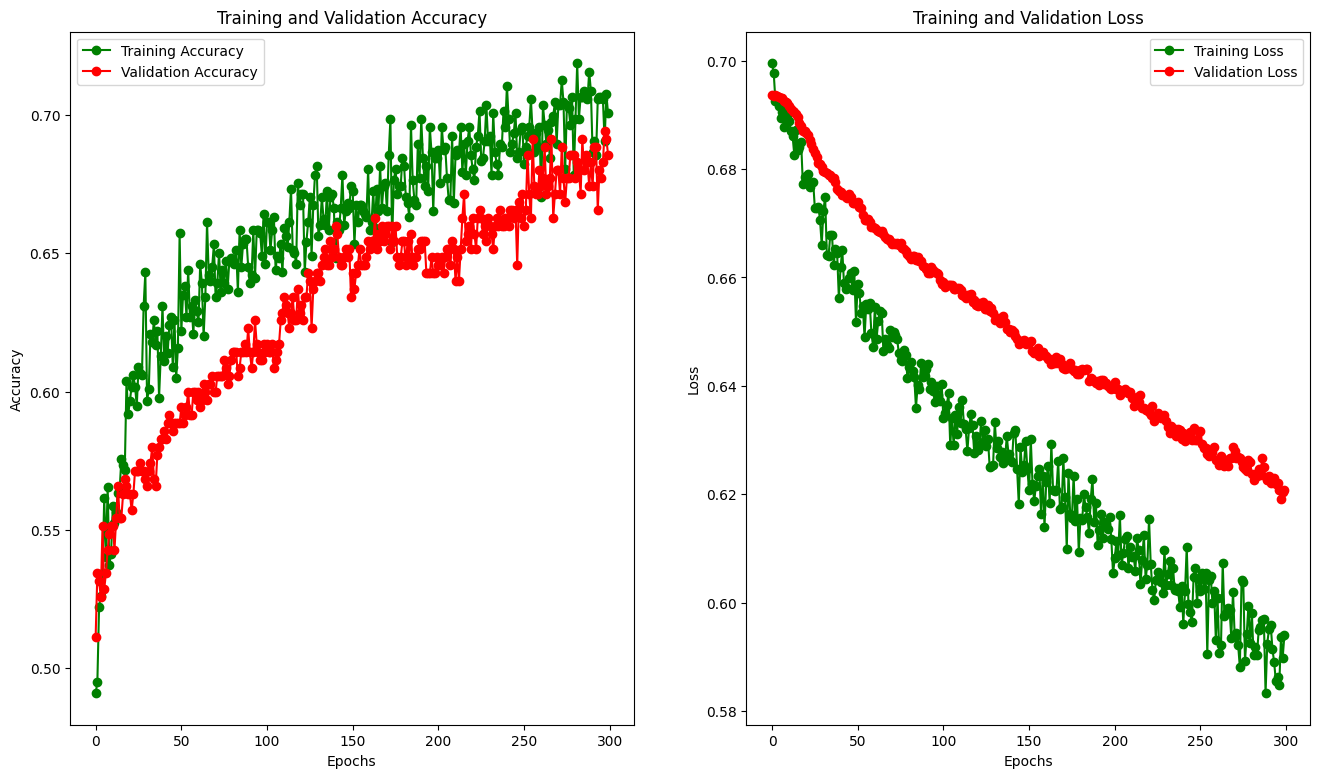

In [192]:
visualize_results (fittedModel2, epoch)

Confusion Matrix

Confusion matrix, without normalization
[[102  73]
 [104  71]]


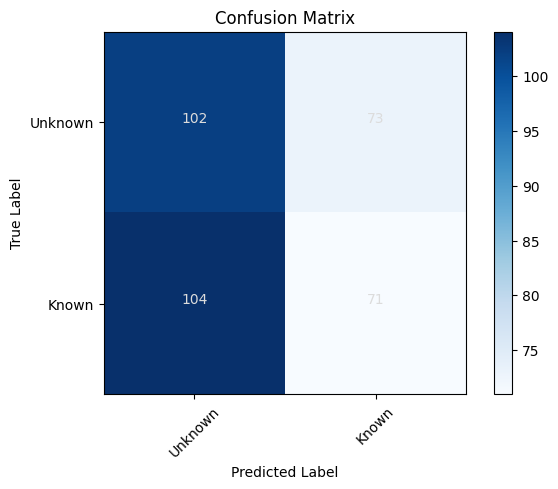

In [193]:
cm = confusion_matrix((y_test), preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=False, title='Confusion Matrix')

Normalized confusion matrix
[[0.58285714 0.41714286]
 [0.59428571 0.40571429]]


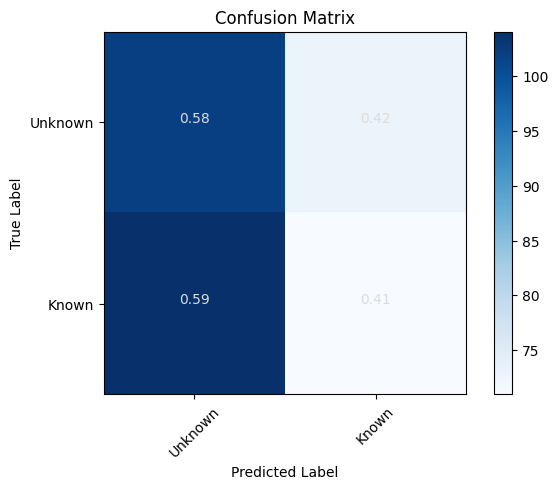

In [194]:
cm = confusion_matrix((y_test), preds)
cm_plot_labels = ['Unknown', 'Known']
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion Matrix')

Save Model

In [195]:
os.mkdir('/content/output/Models')

FileExistsError: [Errno 17] File exists: '/content/output/Models'

In [153]:
EEGNET_Model1.save_weights('/content/output/Models/EEGNEt_Model1.h5')

Save predictions and test labels

In [171]:
import pandas as pd
outputfile = '/content/output/Models/EEGNEt_Model1.csv'
df = pd.DataFrame({'col1': y_test, 'col2': preds})
df.to_csv(outputfile)
